# Data Generation
## Goals
* The main goal of this notebook is to generate training data for mnist object detection project
* We are going to break this task into following sub-tasks
    1. Extend `mnist` dataset with augmented data and bounding boxes
    1. Map the `n` digits to larger 100x100 images which will be used for training
* Both these tasks are further broken down into smaller tasks for easier experimentation. 
* The output of this notebook will be a bunch of reusable functions or scripts that we can use generate different training dataset for different phase of the project

## Import Libraries

In [199]:
## import libraries
import pandas as pd
import numpy as np
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
import PIL.Image

In [2]:
## validate tensorflow 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Constants

In [3]:
data_dir = Path("..","data")
models_dir = Path("..","models")

## Read Data

In [4]:
data = pd.read_csv(Path(data_dir,"raw","raw_mnist_data.csv"))
data.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


## Bounding Box Generatibon

In [58]:
## helper function to plot the mnist data instances
def plot_numbers(image_df):
    ## lets render each image to do a quick visual inspection
    num_instances = image_df.shape[0]
    num_of_columns = 5
    num_of_rows = int(num_instances / num_of_columns) + (1 if int(num_instances % num_of_columns) > 0 else 0)
    fig,axs = plt.subplots(num_of_rows,num_of_columns,figsize=(10,3))    
    axs = axs.ravel()
    for idx in range(0,num_instances,1):
        image_data = image_df.iloc[idx].values.reshape(28, 28)  # MNIST images are 28x28 pixels
        # Render the image using Matplotlib
        axs[idx].imshow(image_data)  # Use 'gray' colormap to render grayscale
        
        
    plt.axis("off") # Remove axes for better visualization    
    plt.show()

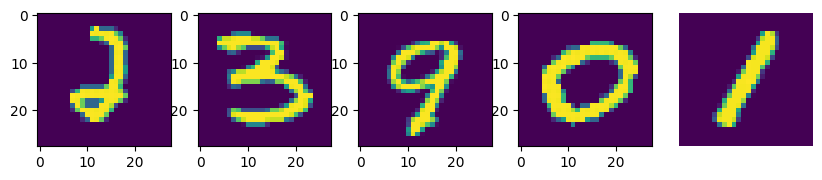

In [170]:
plot_numbers(data.sample(5).drop(columns=["class"]))

In [175]:
## lets use a small sample to test our function as we implement it
test_pixels = data.sample(2)

In [176]:
## helper function to calculate bounding box for each instance and return it. 
def map_bounding_box(mnist_intance):
    padding = 1
    ## save the current class for later
    curr_class = mnist_intance["class"]
    
    ## extract pixel information
    pixels = mnist_intance.drop(labels=["class"])
    ## reshape the pixels 
    pixels = pixels.values.reshape(28,28)
    
    ## calculate active rows & columns
    active_rows = np.sum(pixels,axis=1)
    active_columns = np.sum(pixels, axis=0)
    
    ## calculate x_min and x_max coordinate
    x_min = np.nonzero(active_columns)[0][0]
    x_max = np.nonzero(active_columns)[0][-1]
    y_min = np.nonzero(active_rows)[0][0]
    y_max = np.nonzero(active_rows)[0][-1]

    ## add padding to pixels
    x_min = x_min - (padding if (x_min != 0) else 0)
    x_max = x_max + (padding if (x_max != 27) else 0)
    y_min = y_min - (padding if (y_min != 0) else 0)
    y_max = y_max + (padding if (y_max != 27) else 0)
    
    ## calcualte x_center and y_center
    x_center = round((x_min + x_max) / 2)
    y_center = round((y_min + y_max) / 2)
    
    ## calculate width and height
    width = x_max - x_min + 1
    height = y_max - y_min + 1
    
    return pd.Series({
        "class": curr_class,
        "x_center": x_center,
        "y_center": y_center,
        "width": width,
        "height": height
    })

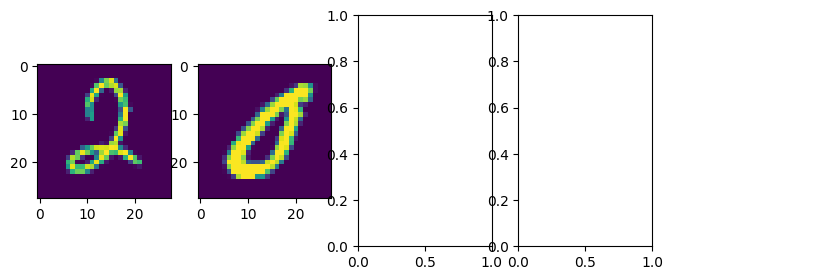

In [177]:
## plot the sample image to mental model 
plot_numbers(test_pixels.drop(columns=["class"]))
test_bounding_box = test_pixels.apply(map_bounding_box,axis=1)

In [178]:
test_bounding_box

,class,x_center,y_center,width,height
53340,2,14,12,18,22
42865,0,14,14,22,22


* So now we have the bounding box coordinates, lets quickly test them by creating the debug function that renders the bounding along with the digit

In [179]:
## since we have class in bounding box dataframe lets drop it from test pixels
test_pixels = test_pixels.drop(columns=["class"])
test_pixels


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
53340,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42865,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [180]:
test_bounding_box

,class,x_center,y_center,width,height
53340,2,14,12,18,22
42865,0,14,14,22,22


## Bounding Box Visualization

In [254]:
## right now we don't know how would we uses this function, for now assumption is we'll pass in 2 dataframes
## we'll revisit the function signature as we proceed with the project
from matplotlib import patches

def visualize_bounding_box(pixel_data, target_data,num_of_columns = 5):
    num_of_columns = num_of_columns if num_of_columns <= 5 else 5
    num_instances = pixel_data.shape[0]
    num_of_rows = int(num_instances / num_of_columns) + (1 if int(num_instances % num_of_columns) > 0 else 0)

    fig,axs = plt.subplots(num_of_rows,num_of_columns,figsize=(10,3))    
    axs = axs.ravel()

    for idx in range(0,num_instances,1):

        original = tf.constant(pixel_data.iloc[idx].values.reshape(28,28,1))
        converted = tf.image.grayscale_to_rgb(original)
        
        x_center = target_data.iloc[idx]["x_center"]
        y_center = target_data.iloc[idx]["y_center"]
        width = target_data.iloc[idx]["width"]
        height = target_data.iloc[idx]["height"]
        
        x = round(x_center - (width) / 2)
        y = round(y_center - (height) / 2)

        rect = patches.Rectangle((x,y),width=width,height=height, linewidth=1, edgecolor='r', facecolor='none')
        image_data = converted.numpy().astype("uint8")
        axs[idx].imshow(image_data)
        axs[idx].add_patch(rect)
        
        axs[idx].set_title(target_data.iloc[idx]["class"])
        axs[idx].axis("off")
    plt.show()

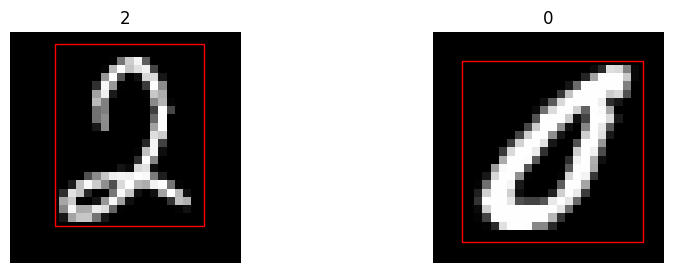

In [255]:
visualize_bounding_box(test_pixels,test_bounding_box, num_of_columns=2)